In [308]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import svm, grid_search, datasets
import operator
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
%matplotlib inline

In [309]:
train_data = pd.read_csv('train.txt')
train_data = train_data.drop('id', axis=1)
train_label = pd.read_csv('target_train.txt', index_col='id')
train_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [361]:
train_label = pd.read_csv('target_train.txt', index_col='id')
train_label = train_label[1:]

In [310]:
accord_edu = {}
for i in range(len(train_data[[4]])):
    if accord_edu.get(train_data[[3]].loc[i][0]):
        if not accord_edu[train_data[[3]].loc[i][0]] == train_data[[4]].loc[i][0]:
            print train_data[[3]].loc[i][0], accord_edu[train_data[[3]].loc[i][0]], train_data[[4]].loc[i][0]
    else:
        accord_edu[train_data[[3]].loc[i][0]] = train_data[[4]].loc[i][0]

In [311]:
num_to_names = {0: ' age', 1: ' workclass', 2: ' fnlwgt', 3: ' education', 4: ' education-num', 5: ' marital-status', 
        6: ' occupation', 7: ' relationship', 8: ' race', 9: ' sex', 10: ' capital-gain', 11: ' captal-loss', 
        12: ' hours-per-week', 13: ' native-country'}

names_to_num = {'age': 0, 'workclass': 1, 'fnlwgt': 2, 'education': 3, 'education-num': 4, 'marital-status': 5, 
        'occupation': 6, 'relationship': 7, 'race': 8, 'sex': 9, 'capital-gain': 10, 'captal-loss': 11, 
        'hours-per-week': 12, 'native-country': 13}

In [312]:
def count_frequency(data, i):
    frequency = {}
    for j in range(len(data[[i]])):
        count = frequency.get(data[[i]].loc[j][0], 0)
        count += 1
        frequency[data[[i]].loc[j][0]] = count
    print num_to_names[i], frequency
    return frequency

In [313]:
def process_rare(data):
    for i in [1, 3, 5, 6, 7, 8, 9, 13]:
        frequency = count_frequency(data, i)

        summa = sum(frequency.values())
        for key, value in frequency.iteritems():
            if float(value) > 0.007*summa:
                continue

            data[num_to_names[i]].replace(to_replace=key, value='Rare', inplace=True)
        count_frequency(data, i)
        print 
    return data
        
train_data = process_rare(train_data)

 workclass {' Private': 15680, ' Self-emp-inc': 767, ' State-gov': 883, ' Local-gov': 1468, ' Without-pay': 8, ' Self-emp-not-inc': 1798, ' Federal-gov': 684, ' Never-worked': 4, ' ?': 1269}
 workclass {' Private': 15680, 'Rare': 12, ' Self-emp-inc': 767, ' State-gov': 883, ' Local-gov': 1468, ' Self-emp-not-inc': 1798, ' Federal-gov': 684, ' ?': 1269}

 education {' 7th-8th': 442, ' Prof-school': 380, ' 1st-4th': 111, ' Assoc-voc': 951, ' Masters': 1185, ' Assoc-acdm': 714, ' 9th': 351, ' Doctorate': 282, ' Bachelors': 3738, ' 5th-6th': 224, ' Some-college': 5050, ' 10th': 652, ' 11th': 818, ' HS-grad': 7353, ' Preschool': 32, ' 12th': 278}
 education {' 7th-8th': 442, ' Prof-school': 380, 'Rare': 143, ' Assoc-voc': 951, ' Masters': 1185, ' Assoc-acdm': 714, ' 9th': 351, ' Doctorate': 282, ' Bachelors': 3738, ' 5th-6th': 224, ' Some-college': 5050, ' 10th': 652, ' 11th': 818, ' HS-grad': 7353, ' 12th': 278}

 marital-status {' Separated': 703, ' Divorced': 3104, ' Married-spouse-absen

In [314]:
data = train_data

In [316]:
train_data[num_to_names[4]].replace(to_replace=accord_edu[' Preschool'], value= accord_edu[' 1st-4th'], inplace=True)

In [317]:
data = train_data

In [318]:
train_data = train_data.drop(' education', axis=1)
train_data.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Rare


In [159]:
all_money = []
for i in range(len(train_data[[9]])):
    if int(train_data[[9]].loc[i][0]) != 99999:
        all_money.append(int(train_data[[9]].loc[i][0]))

money = {}
for i in range(len(all_money)):
    amount = money.get(all_money[i], 0)
    amount += 1
    money[all_money[i]] = amount
print money.values()

train_data[' capital-gain'].replace(to_replace=99999, value=money.values()[0], inplace=True)

[20713, 5, 13, 17, 2, 7, 1, 3, 20, 4, 9, 29, 2, 192, 7, 63, 2, 19, 1, 8, 2, 22, 25, 1, 3, 11, 3, 1, 15, 3, 3, 37, 6, 13, 168, 8, 1, 13, 14, 3, 223, 17, 21, 64, 19, 9, 4, 2, 6, 17, 4, 36, 12, 33, 5, 8, 20, 3, 4, 3, 29, 4, 4, 55, 3, 3, 5, 8, 5, 10, 1, 24, 18, 6, 8, 15, 4, 6, 2, 8, 4, 10, 2, 3, 9, 6, 4, 2, 1, 6, 15, 5, 3, 2, 6, 5, 48, 9, 2, 8, 5, 4, 35, 1, 1, 3, 3, 1, 5, 1, 2, 32, 7, 1, 1, 3]


In [160]:
all_lost_money = []
for i in range(len(train_data[[10]])):
    if int(train_data[[10]].loc[i][0]) != 99999:
        all_lost_money.append(int(train_data[[10]].loc[i][0]))

money = {}
for i in range(len(all_lost_money)):
    amount = money.get(all_lost_money[i], 0)
    amount += 1
    money[all_lost_money[i]] = amount
print money.values()

[21506, 1, 3, 12, 21, 1, 4, 12, 33, 6, 28, 4, 3, 6, 120, 10, 1, 2, 1, 1, 10, 2, 6, 2, 5, 11, 2, 18, 25, 3, 1, 1, 8, 5, 16, 13, 2, 3, 5, 2, 27, 13, 17, 3, 1, 13, 3, 3, 2, 6, 2, 2, 13, 2, 2, 1, 33, 1, 2, 9, 34, 6, 96, 4, 4, 143, 36, 5, 1, 14, 6, 1, 2, 2, 11, 1, 17, 36, 2, 17, 15, 15, 3, 3, 2, 6, 9]


In [319]:
data_2 = train_data

In [164]:
train_data[' capital-gain'].replace(to_replace=0, value=1, inplace=True)
train_data[' capital-loss'].replace(to_replace=0, value=1, inplace=True)
train_data[' hours-per-week'].replace(to_replace=0, value=1, inplace=True)
train_data[' fnlwgt'].replace(to_replace=0, value=1, inplace=True)

In [165]:
train_data[' hours-per-week'] = np.log(train_data[' hours-per-week'])
train_data[' capital-gain'] = np.log(train_data[' capital-gain'])
train_data[' capital-loss'] = np.log(train_data[' capital-loss'])
train_data[' fnlwgt'] = np.log(train_data[' fnlwgt'])

In [237]:
def normalize(data, features):
    data_norm = data
    for feature in features:
        data_norm[feature] = (data[feature] - data[feature].mean()) / (data[feature].max() - data[feature].min())
    return data_norm
    
train_data_norm = normalize(train_data, [' hours-per-week', ' capital-gain', ' capital-loss', ' fnlwgt'])

In [241]:
train_data = data_2
train_data_norm.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,-0.151398,13,Never-married,Adm-clerical,Not-in-family,White,Male,0.655708,-0.041865,0.011540,United-States
1,50,Self-emp-not-inc,-0.136361,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,-0.067260,-0.041865,-0.233052,United-States
2,38,Private,0.061999,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,-0.067260,-0.041865,0.011540,United-States
3,53,Private,0.079678,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,-0.067260,-0.041865,0.011540,United-States
4,28,Private,0.155984,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,-0.067260,-0.041865,0.011540,Rare


In [320]:
def replace_quest(data, features):
    for feature in features:
        dictionary = {}
        for j in range(len(data[feature])):
            count = dictionary.get(data[feature].loc[j][0], 0)
            count += 1
            dictionary[data[feature].loc[j][0]] = count
            
            median_value = np.median(dictionary.values())
            for key, value in dictionary.iteritems():
                if value == median_value:
                    data[feature].replace(to_replace=' ?', value=key, inplace=True)
                    break
    return data
    
train_data = replace_quest(train_data, [' workclass', ' marital-status', ' occupation', ' relationship', 
                                                 ' race', ' sex', ' native-country'])

In [321]:
train_data.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Rare


In [322]:
def number_encode_features(train_data):
    result = train_data.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

encoded_data, encoders = number_encode_features(train_data)
train_data = encoded_data
train_data.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,6,77516,13,3,1,1,4,1,2174,0,40,2
1,50,5,83311,13,1,3,0,4,1,0,0,13,2
2,38,3,215646,9,0,5,1,4,1,0,0,40,2
3,53,3,234721,7,1,5,0,2,1,0,0,40,2
4,28,3,338409,13,1,8,5,2,0,0,0,40,3


In [180]:
train_data_norm = pd.get_dummies(train_data_norm, columns=[' workclass', ' marital-status', ' occupation', ' relationship', 
                                                 ' race', ' sex', ' native-country'])

In [369]:
train_data.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,6,77516,13,3,1,1,4,1,2174,0,40,2
1,50,5,83311,13,1,3,0,4,1,0,0,13,2
2,38,3,215646,9,0,5,1,4,1,0,0,40,2
3,53,3,234721,7,1,5,0,2,1,0,0,40,2
4,28,3,338409,13,1,8,5,2,0,0,0,40,3


In [367]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor(loss='huber', n_iter=100)
sgd.fit(train_data, np.ravel(train_label))

train = np.array(train_data)
train = np.hstack((train, sgd.predict(train_data)[None].T))

In [368]:
train

array([[  3.90000000e+01,   6.00000000e+00,   7.75160000e+04, ...,
          4.00000000e+01,   2.00000000e+00,  -2.13953427e+05],
       [  5.00000000e+01,   5.00000000e+00,   8.33110000e+04, ...,
          1.30000000e+01,   2.00000000e+00,  -2.31416483e+05],
       [  3.80000000e+01,   3.00000000e+00,   2.15646000e+05, ...,
          4.00000000e+01,   2.00000000e+00,  -5.99106922e+05],
       ..., 
       [  4.20000000e+01,   3.00000000e+00,   6.84690000e+04, ...,
          4.00000000e+01,   2.00000000e+00,  -1.90141182e+05],
       [  6.30000000e+01,   5.00000000e+00,   2.76530000e+04, ...,
          3.50000000e+01,   2.00000000e+00,  -7.67102276e+04],
       [  2.10000000e+01,   3.00000000e+00,   4.10439000e+05, ...,
          2.40000000e+01,   2.00000000e+00,  -1.14042359e+06]])

In [370]:
from sklearn.cluster import KMeans
k7 = KMeans(n_clusters=7, precompute_distances = True, n_jobs=-1)
k7.fit(train)
k3 = KMeans(n_clusters=3, precompute_distances = True, n_jobs=-1)
k3.fit(train)

train = np.hstack((train, k7.predict(train)[None].T, k3.predict(train)[None].T))

In [371]:
train

array([[  3.90000000e+01,   6.00000000e+00,   7.75160000e+04, ...,
         -2.13953427e+05,   0.00000000e+00,   0.00000000e+00],
       [  5.00000000e+01,   5.00000000e+00,   8.33110000e+04, ...,
         -2.31416483e+05,   0.00000000e+00,   0.00000000e+00],
       [  3.80000000e+01,   3.00000000e+00,   2.15646000e+05, ...,
         -5.99106922e+05,   2.00000000e+00,   2.00000000e+00],
       ..., 
       [  4.20000000e+01,   3.00000000e+00,   6.84690000e+04, ...,
         -1.90141182e+05,   0.00000000e+00,   0.00000000e+00],
       [  6.30000000e+01,   5.00000000e+00,   2.76530000e+04, ...,
         -7.67102276e+04,   0.00000000e+00,   0.00000000e+00],
       [  2.10000000e+01,   3.00000000e+00,   4.10439000e+05, ...,
         -1.14042359e+06,   5.00000000e+00,   1.00000000e+00]])

In [324]:
test_data = pd.read_csv('test.txt')
test_data = test_data.drop('id', axis=1)

In [325]:
test_data = process_rare(test_data)

 workclass {' Private': 7016, ' Self-emp-inc': 349, ' State-gov': 415, ' Local-gov': 625, ' Without-pay': 6, ' Self-emp-not-inc': 743, ' Federal-gov': 276, ' Never-worked': 3, ' ?': 567}
 workclass {' Private': 7016, 'Rare': 9, ' Self-emp-inc': 349, ' State-gov': 415, ' Local-gov': 625, ' Self-emp-not-inc': 743, ' Federal-gov': 276, ' ?': 567}

 education {' 7th-8th': 204, ' Prof-school': 196, ' 1st-4th': 57, ' 9th': 163, ' Assoc-voc': 431, ' Masters': 538, ' Assoc-acdm': 353, ' 12th': 155, ' Doctorate': 131, ' Bachelors': 1617, ' 5th-6th': 109, ' Some-college': 2241, ' 10th': 281, ' 11th': 357, ' HS-grad': 3148, ' Preschool': 19}
 education {' 7th-8th': 204, ' Prof-school': 196, 'Rare': 76, ' 9th': 163, ' Assoc-voc': 431, ' Masters': 538, ' Assoc-acdm': 353, ' 12th': 155, ' Doctorate': 131, ' Bachelors': 1617, ' 5th-6th': 109, ' Some-college': 2241, ' 10th': 281, ' 11th': 357, ' HS-grad': 3148}

 marital-status {' Separated': 322, ' Divorced': 1339, ' Married-spouse-absent': 115, ' Wi

In [326]:
test_data[num_to_names[4]].replace(to_replace=2, value=1, inplace=True)

In [327]:
test_data_norm = test_data.drop(' education', axis=1)
#test_data_norm
test_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,28,Private,37821,Assoc-voc,11,Never-married,Sales,Unmarried,White,Female,0,0,55,?
1,45,Private,228570,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,35,United-States
2,21,Private,141453,HS-grad,9,Never-married,Other-service,Own-child,White,Female,0,0,40,United-States
3,34,Private,88215,Masters,14,Married-civ-spouse,Prof-specialty,Wife,Asian-Pac-Islander,Female,0,0,40,Rare
4,53,Private,48641,12th,8,Never-married,Other-service,Not-in-family,Other,Female,0,0,35,United-States


In [207]:
test_data[' capital-gain'].replace(to_replace=99999, value=money.values()[0], inplace=True)

In [208]:
test_data[' capital-gain'].replace(to_replace=0, value=1, inplace=True)
test_data[' capital-loss'].replace(to_replace=0, value=1, inplace=True)
test_data[' hours-per-week'].replace(to_replace=0, value=1, inplace=True)
test_data[' fnlwgt'].replace(to_replace=0, value=1, inplace=True)

In [209]:
test_data[' hours-per-week'] = np.log(test_data[' hours-per-week'])
test_data[' capital-gain'] = np.log(test_data[' capital-gain'])
test_data[' capital-loss'] = np.log(test_data[' capital-loss'])
test_data[' fnlwgt'] = np.log(test_data[' fnlwgt'])

In [245]:
test_data_norm = normalize(test_data, [' hours-per-week', ' capital-gain', ' capital-loss', ' fnlwgt'])

In [328]:
test_data = replace_quest(test_data_norm, [' workclass', ' marital-status', ' occupation', ' relationship', 
                                                 ' race', ' sex', ' native-country'])

In [329]:
test_data = test_data.drop(' education', axis=1)

ValueError: labels [' education'] not contained in axis

In [212]:
test_data_norm = pd.get_dummies(test_data_norm, columns=[' workclass', ' marital-status', ' occupation', ' relationship', 
                                                 ' race', ' sex', ' native-country'])

In [330]:
encoded_data, encoders = number_encode_features(test_data)
test_data_norm = encoded_data

In [331]:
test_data_norm.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,28,3,37821,11,3,10,4,4,0,0,0,55,0
1,45,3,228570,9,1,10,5,4,0,0,0,35,2
2,21,3,141453,9,3,7,3,4,0,0,0,40,2
3,34,3,88215,14,1,8,5,1,0,0,0,40,3
4,53,3,48641,8,3,7,1,3,0,0,0,35,2


In [352]:
test  = np.hstack((test_data_norm, sgd.predict(test_data_norm)[None].T))

In [353]:
test  = np.hstack((test,  k7.predict(test)[None].T,  k3.predict(test)[None].T))

In [268]:
X_train, X_test, y_train, y_test = train_test_split(train_data_norm, train_label[1:], test_size=0.2, random_state=1234)

In [254]:
def prediction(x, prob):
    return 0 if x <= prob else 1
prediction = np.vectorize(prediction)

In [255]:
def score(params):
    print "Training with params : "
    print params
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    # watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    model = xgb.train(params, dtrain, num_round)
    predictions = model.predict(dvalid)
    y = prediction(predictions, 0.4)
    score = f1_score(y_test, y)
    print "\tScore {0}\n\n".format(score)
    return {'loss': score, 'status': STATUS_OK}

In [258]:
def optimize(trials):
    space = {
             'n_estimators' : hp.quniform('n_estimators', 500, 1500, 100),
             'eta' : hp.quniform('eta', 0.005, 0., 0.005),
             'max_depth' : hp.quniform('max_depth', 1, 13, 1),
             'min_child_weight' : hp.quniform('min_child_weight', 1, 6, 1),
             'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
             'gamma' : hp.quniform('gamma', 0.1, 1, 0.05),
             'lambda' : hp.quniform('lambda', 0.1, 1, 0.05),
             'alpha' : hp.quniform('alpha', 0.1, 1, 0.05),
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
             'eval_metric': 'ndcg',
             'objective': 'binary:logistic',
             'nthread' : 6,
             'silent' : 1
             }

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=400)

    print best

In [259]:
trials = Trials()

optimize(trials)

Training with params : 
{'colsample_bytree': 0.8500000000000001, 'silent': 1, 'eval_metric': 'ndcg', 'nthread': 6, 'min_child_weight': 2.0, 'n_estimators': 500.0, 'subsample': 0.8500000000000001, 'eta': 0.195, 'objective': 'binary:logistic', 'alpha': 0.55, 'max_depth': 8.0, 'gamma': 0.5, 'lambda': 0.75}
	Score 0.67192575406


Training with params : 
{'colsample_bytree': 0.7000000000000001, 'silent': 1, 'eval_metric': 'ndcg', 'nthread': 6, 'min_child_weight': 4.0, 'n_estimators': 900.0, 'subsample': 0.55, 'eta': 0.135, 'objective': 'binary:logistic', 'alpha': 0.35000000000000003, 'max_depth': 6.0, 'gamma': 0.35000000000000003, 'lambda': 0.45}
	Score 0.670914883933


Training with params : 
{'colsample_bytree': 0.7000000000000001, 'silent': 1, 'eval_metric': 'ndcg', 'nthread': 6, 'min_child_weight': 4.0, 'n_estimators': 300.0, 'subsample': 0.75, 'eta': 0.105, 'objective': 'binary:logistic', 'alpha': 0.6000000000000001, 'max_depth': 3.0, 'gamma': 0.8, 'lambda': 0.2}
	Score 0.700689655172


KeyboardInterrupt: 

In [376]:
params = {'silent': False, 'nthread': 10, 'max_depth': 8, 'n_estimators': 3400, 
                        'subsample': 0.5, 'learning_rate': 0.01, 'seed': 202, 'eta': 0.007}

In [282]:
param = {}
param['objective'] = ['binary:logistic']
param['reg_alpha'] = [float(i)/5 for i in range(0, 6)]
param['colsample_bytree'] = [float(i)/6 for i in range(3, 6)]
param['subsample'] = [float(i)/6 for i in range(3, 6)]
param['nthread'] = [6]
param['max_delta_step'] = [0.009]
param['n_estimators'] = [2000]

dtrain = xgb.DMatrix(train_data_norm, label=train_label[1:])
dtest = xgb.DMatrix(test_data_norm)

xgc = xgb.XGBClassifier()
clf = grid_search.GridSearchCV(xgc, param, n_jobs=-1, verbose=1, scoring='f1')
clf.fit(np.array(train_data_norm), train_label[1:].values.T[0])

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 16.5min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'reg_alpha': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 'colsample_bytree': [0.5, 0.6666666666666666, 0.8333333333333334], 'max_delta_step': [0.009], 'nthread': [6], 'n_estimators': [2000], 'subsample': [0.5, 0.6666666666666666, 0.8333333333333334], 'objective': ['binary:logistic']},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=1)

In [292]:
clf.predict(test_data_norm)

array([0, 0, 0, ..., 0, 0, 1])

In [305]:
y = clf.predict_proba(test_data_norm)

In [306]:
y = [1-x[0] for x in y]
y = prediction(y, 0.4)

In [233]:
dtrain = xgb.DMatrix(train_data_norm, label=train_label[1:])
dtest = xgb.DMatrix(test_data_norm)
clf = xgb.train(params, dtrain, num_boost_round=1000)
p = clf.predict(dtest)

In [234]:
p = prediction(p, 0.4)

In [285]:
wtf = pd.read_csv('test.txt', index_col='id')

In [307]:
pd.DataFrame(y, columns=['target'], index=wtf.index).to_csv('mm1.csv')

In [335]:
def validate(train, label, test, val):
    dtrain = xgb.DMatrix(train, label=label)
    dtest = xgb.DMatrix(test)
    
    num_boost_round=1500
    clf = xgb.train(params, dtrain, num_boost_round=num_boost_round)
    errors = np.array([f1_score(val,
                                    prediction(clf.predict(dtest, ntree_limit=n + 1), 0.37))
                     for n in range(num_boost_round)])
    
    best_alpha_gbr = np.argmax(errors)
    print 'Best n is:', best_alpha_gbr
    print 'corresponding f1', max(errors)
    
    
    plt.figure(figsize=(14, 6))
    plt.plot(range(num_boost_round), errors)

    plt.axvline(x=best_alpha_gbr, color='r')

    plt.show()

Best n is: 665
corresponding f1 0.708167770419


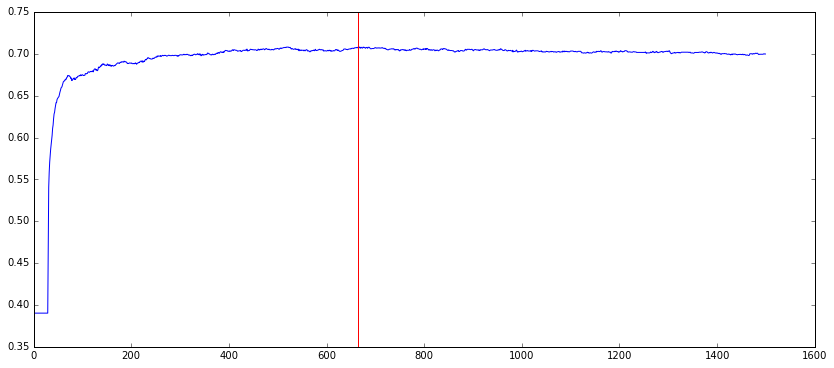

In [336]:
train_1 = train_data[len(train_data)/3:]
train_label_1 = train_label[len(train_data)/3:]
test_1 = train_data[:len(train_data)/3]
val_1 = train_label[:len(train_data)/3]
#print val_1

validate(X_train, y_train, X_test, y_test)

Best n is: 376
corresponding f1 0.724266666667


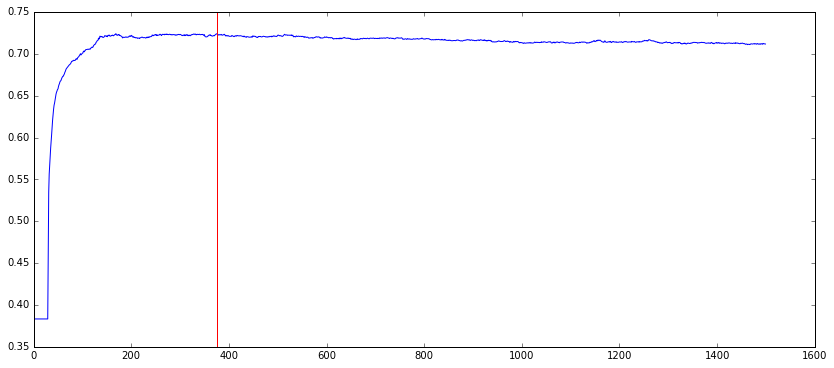

In [339]:
train_label = train_label[1:]
train_1 = train_data[:2*len(train_data)/3]
train_label_1 = train_label[:2*len(train_data)/3]
test_1 = train_data[2*len(train_data)/3:]
val_1 = train_label[2*len(train_data)/3:]

validate(train_1, train_label_1, test_1, val_1)

Best n is: 667
corresponding f1 0.721693121693


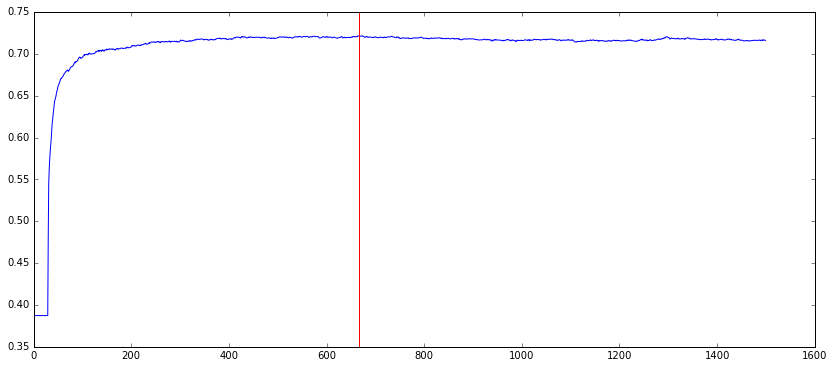

In [345]:
train_1 = train[len(train_data)/3:]
train_label_1 = train_label[len(train_data)/3:]
test_1 = train[:len(train_data)/3]
val_1 = train_label[:len(train_data)/3]

validate(train_1, train_label_1, test_1, val_1)

Best n is: 366
corresponding f1 0.728


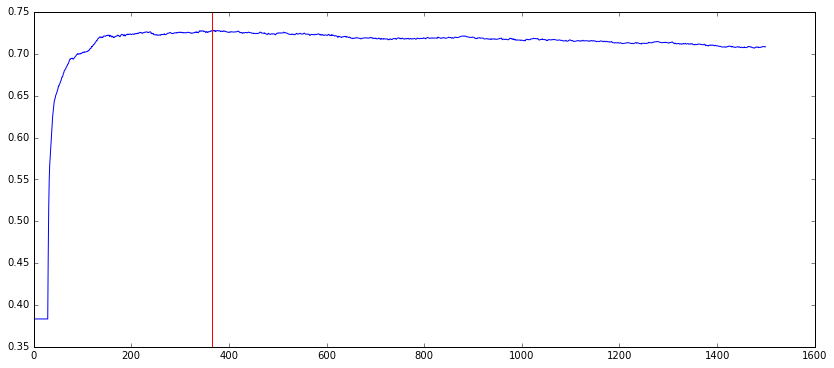

In [372]:
train_1 = train[:2*len(train_data)/3]
train_label_1 = train_label[:2*len(train_data)/3]
test_1 = train[2*len(train_data)/3:]
val_1 = train_label[2*len(train_data)/3:]

validate(train_1, train_label_1, test_1, val_1)

Best n is: 846
corresponding f1 0.723235527359


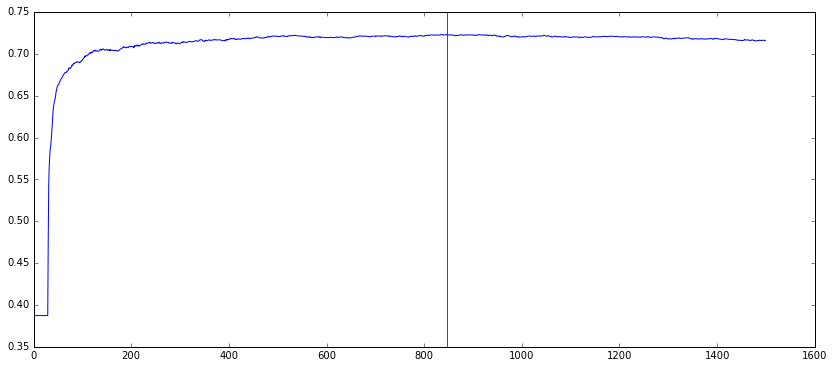

In [374]:
train_1 = train[len(train_data)/3:]
train_label_1 = train_label[len(train_data)/3:]
test_1 = train[:len(train_data)/3]
val_1 = train_label[:len(train_data)/3]

validate(train_1, train_label_1, test_1, val_1)

Best n is: 234
corresponding f1 0.726271630834


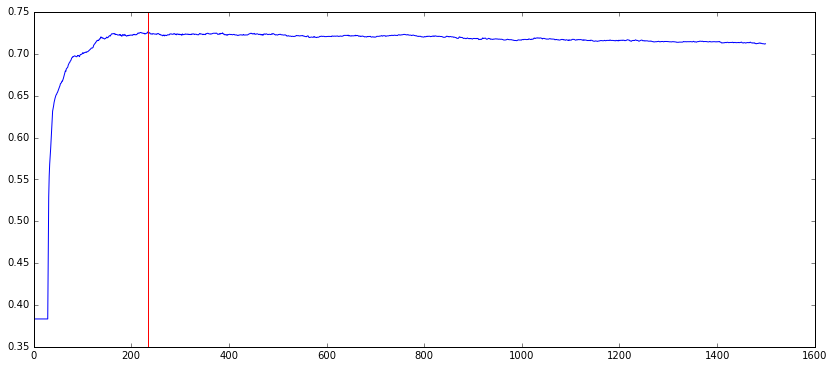

In [375]:
train_1 = train[:2*len(train_data)/3]
train_label_1 = train_label[:2*len(train_data)/3]
test_1 = train[2*len(train_data)/3:]
val_1 = train_label[2*len(train_data)/3:]

validate(train_1, train_label_1, test_1, val_1)

In [378]:
dtrain = xgb.DMatrix(train, label=train_label)
dtest = xgb.DMatrix(test)

num_boost_round=900
clf = xgb.train(paramspd.DataFrame(y, columns=['target'], index=wtf.index).to_csv('mm2.csv'), dtrain, num_boost_round=num_boost_round)
y = clf.predict(dtest)

In [379]:
y = prediction(y, 0.37)

In [380]:
pd.DataFrame(y, columns=['target'], index=wtf.index).to_csv('mm2.csv')